# Tensorflow2 KeyNotes
### ==== Signal Denoise with Autoencoder Neural Networks (TF2) ====
### Instructions

These serial notebooks are intended to record my practicing and keynotes with deep learning in the framework of TensorFlow 2. Within these notebooks, I demonstrate the networks with specific examples and my personal interpretations.  You can find instructions in each section for each project.  Feel free to refer to it if is helpful for your work. 

In this notebook, I demonstrate the time series/signals denoising by using auto-encoder neural network architectures, the results derived from different auto-encoder neural networks are compared. The following contents are included in this notebook:

1. Time series denoising with dense autoencoder neural network
2. Time series denoising with convolutional autoencoder neural network


### Code by Hao, Zhao, Nov., 2020.



### Import the tensorflow library

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0



###  Load the external libraries

In [2]:
import numpy as np
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.fftpack
import time

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Dense,BatchNormalization,Dropout,Conv1D,SimpleRNN,AveragePooling1D,Flatten


### Generate a synthetic time series based on sinusoid signals



In [3]:
dt,t_min,t_max = 0.001,0,20 
t              = np.linspace(t_min,t_max,int((t_max-t_min)/dt+1))
f0,f1          = 30,60 
noise_scale    = 0.3
baseline_slope = 0.1
syn_sig        = np.sin((2*np.pi*f0)*t)  +  1 / np.exp(t) * np.sin((2*np.pi*f1)*t) + baseline_slope * t
syn_data       = syn_sig + noise_scale*np.random.normal(0,1,len(syn_sig))

# apply the min-max feature scaling if needed
# syn_sig   = (syn_sig -syn_sig.min())/(syn_sig.max() -syn_sig.min())
# syn_data  = (syn_data -syn_data.min())/(syn_data.max() -syn_data.min())


### Plot the generated time series

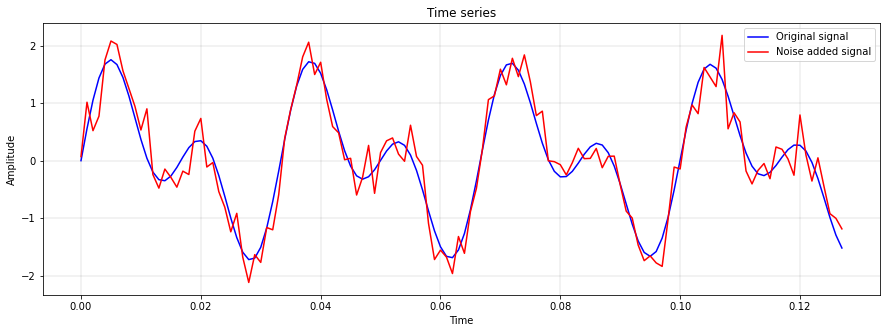

In [4]:

#set the samples to display
N=128

plt.figure(0,figsize=(15, 5))
plt.plot(t[0:N],syn_sig[0:N],'b',label='Original signal')
plt.plot(t[0:N],syn_data[0:N],'r',label='Noise added signal') 
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Time series')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()


### Dataset preprocessing to generate the training and testing datasets

In [5]:
# define the function for datasets generation 
def dataset_generation(time_series,time_series_noiseAdded,batch_size,window_step,predict_step):
    
    # derive the total batch numbers
    n_batch = ((len(t))-batch_size)//window_step + 1
    
    # derive the datasets: input (x) and tartget (y)
    dataset_x     = []
    dataset_y     = []    
    train_set_x   = []
    train_set_y   = []
    test_set_x    = []
    test_set_y    = []
    
    # loop through the time series and gernerate the data
    for n in np.arange(1,n_batch+1):
        
        data_batch_x = time_series_noiseAdded[(0+(n-1)*window_step):(batch_size+(n-1)*window_step)] 
        data_batch_y = time_series[(0+(n-1)*window_step):(batch_size+(n-1)*window_step)] 
        
        dataset_x  = np.concatenate((dataset_x, data_batch_x))
        dataset_y  = np.concatenate((dataset_y, data_batch_y))
        
    # reshape datasets to 2d dimension: batch x dataset
    dataset_x = np.reshape(dataset_x, newshape=(n_batch,batch_size))
    dataset_y = np.reshape(dataset_y, newshape=(n_batch,batch_size))
    
    # split the dataset into train 80% and test sets (20%)
    train_samples  = int(len(dataset_x) * 0.8) 

    train_set_x = dataset_x[:train_samples,:]
    train_set_y = dataset_y[:train_samples,:]

    test_set_x  = dataset_x[train_samples:,:]
    test_set_y  = dataset_y[train_samples:,:] 
        
    return train_set_x,train_set_y,test_set_x,test_set_y
    

# generate the datasets 
batch_size   = 128
window_step  = batch_size//16
predict_step = 10

train_set_x,train_set_y,test_set_x,test_set_y = dataset_generation(syn_sig,syn_data,batch_size,window_step,predict_step)

print('train_set_x: has shape {}'.format(train_set_x.shape))
print('train_set_y: has shape {}'.format(train_set_y.shape))
print('test_set_x: has shape {}'.format(test_set_x.shape))
print('test_set_y: has shape {}'.format(test_set_y.shape))



train_set_x: has shape (1988, 128)
train_set_y: has shape (1988, 128)
test_set_x: has shape (497, 128)
test_set_y: has shape (497, 128)


----------------------------------------------------------------------
## Method-1: Dense Autoencoder Neural Network
----------------------------------------------------------------------


 ### Build the neural network 

In [6]:
Denoise_autoencoder = Sequential([
                    Input(shape=(batch_size,)),
                    Dense(64,activation='relu'),
                    Dense(32,activation='relu'),
                    Dense(64,activation='relu'),
                    Dense(batch_size)
                    ])

Denoise_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=['mae'])

Denoise_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
Total params: 20,768
Trainable params: 20,768
Non-trainable params: 0
_________________________________________________________________


### Train the neural network

In [7]:
start      = time.time()
history    = Denoise_autoencoder.fit(train_set_x,train_set_y,epochs=100,validation_split=0.20,verbose=1)
trian_time = time.time()-start
print("Training completed in : {:0.2f}ms".format(1000*trian_time))


Epoch 1/100
50/50 [==============================] - 0s 4ms/step - loss: 0.5907 - mae: 0.6143 - val_loss: 0.1796 - val_mae: 0.3346
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0860 - mae: 0.2130 - val_loss: 0.0341 - val_mae: 0.1474
Epoch 3/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0322 - mae: 0.1276 - val_loss: 0.0218 - val_mae: 0.1172
Epoch 4/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0232 - mae: 0.1087 - val_loss: 0.0192 - val_mae: 0.1112
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0182 - mae: 0.0981 - val_loss: 0.0148 - val_mae: 0.0973
Epoch 6/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0148 - mae: 0.0899 - val_loss: 0.0127 - val_mae: 0.0899
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0119 - mae: 0.0818 - val_loss: 0.0125 - val_mae: 0.0895
Epoch 8/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0096 - m

50/50 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0343 - val_loss: 0.0052 - val_mae: 0.0585
Epoch 64/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0344 - val_loss: 0.0047 - val_mae: 0.0556
Epoch 65/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0347 - val_loss: 0.0040 - val_mae: 0.0509
Epoch 66/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0346 - val_loss: 0.0069 - val_mae: 0.0680
Epoch 67/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0339 - val_loss: 0.0048 - val_mae: 0.0558
Epoch 68/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0337 - val_loss: 0.0034 - val_mae: 0.0466
Epoch 69/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0340 - val_loss: 0.0053 - val_mae: 0.0589
Epoch 70/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0

### Display of training and validation losses in the network training


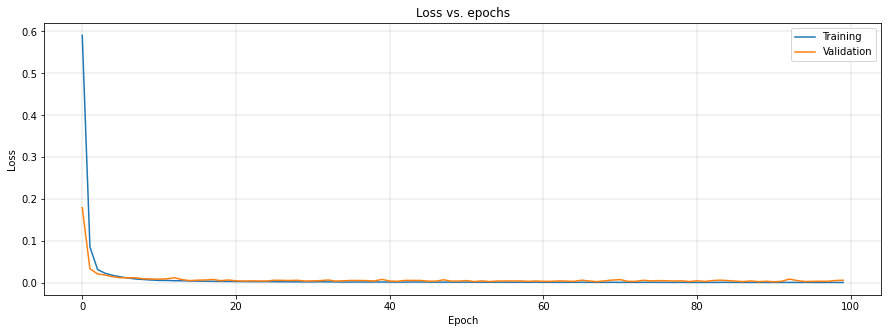

In [8]:
plt.figure(2,figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

### Time series denoising with trainned denoise autoencoder neural network


In [9]:
denoised_predictions = Denoise_autoencoder.predict(test_set_x)

### Compare the noise contaminated dataset and auto-encoder denoised dataset



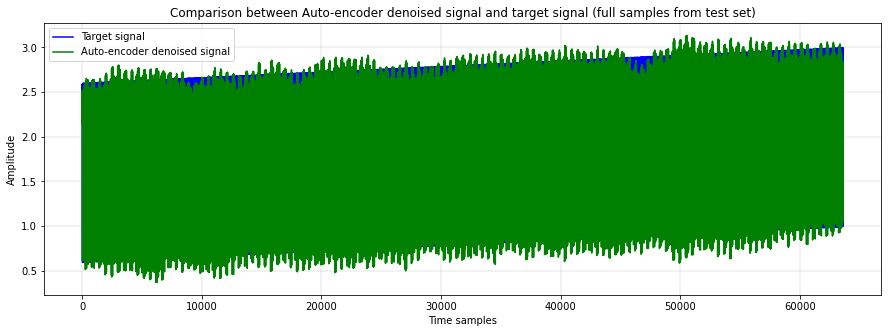

In [10]:
# check the auto-encoder denoised signal on the whole test dataset

plt.figure(3,figsize=(15, 5))
plt.plot(test_set_y[:,:].flatten(),'b',label='Target signal')
plt.plot(denoised_predictions[:,:].flatten(),'g',label='Auto-encoder denoised signal')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.title('Comparison between Auto-encoder denoised signal and target signal (full samples from test set)')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

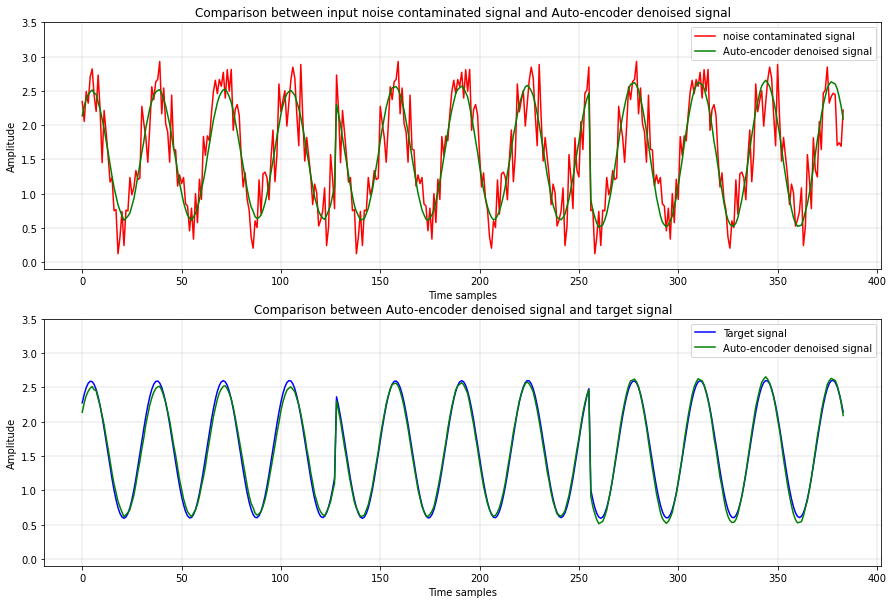

In [11]:
# select the denoised signal from the test sets for QC comparison

fig = plt.figure(4,figsize=(15, 10))

ax  = fig.add_subplot(2,1,1)
ax.plot(test_set_x[:3,:].flatten(),'r',label='noise contaminated signal')
ax.plot(denoised_predictions[:3,:].flatten(),'g',label='Auto-encoder denoised signal')
ax.set_xlabel('Time samples')
ax.set_ylabel('Amplitude')
ax.set_title('Comparison between input noise contaminated signal and Auto-encoder denoised signal')
ax.set_ylim(-0.10, 3.5)
ax.legend(loc='upper right')
ax.grid(color='k', linestyle='-', linewidth=0.1)

ax  = fig.add_subplot(2,1,2)
ax.plot(test_set_y[:3,:].flatten(),'b',label='Target signal')
ax.plot(denoised_predictions[:3,:].flatten(),'g',label='Auto-encoder denoised signal')
ax.set_xlabel('Time samples')
ax.set_ylabel('Amplitude')
ax.set_title('Comparison between Auto-encoder denoised signal and target signal')
ax.set_ylim(-0.10, 3.5)
ax.legend(loc='upper right')
ax.grid(color='k', linestyle='-', linewidth=0.1)


### Recheck the denoised signal on the initial plot

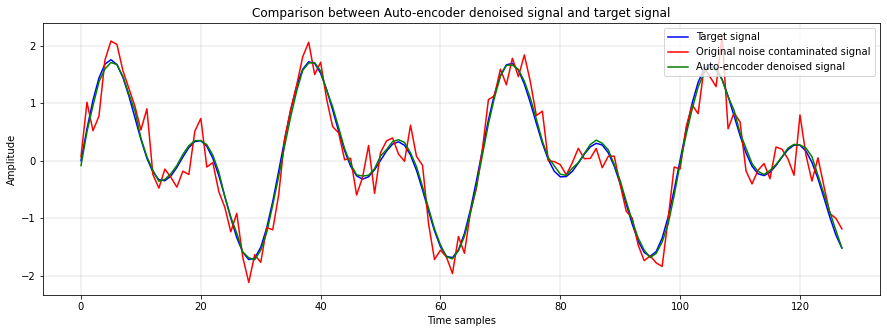

In [12]:
qc_test_set_x = syn_data[0:128]
qc_test_set_y = syn_sig[0:128]
denoised_predictions = Denoise_autoencoder.predict(qc_test_set_x[np.newaxis,...])

plt.figure(4,figsize=(15, 5))
plt.plot(qc_test_set_y,'b',label='Target signal')
plt.plot(qc_test_set_x,'r',label='Original noise contaminated signal')
plt.plot(denoised_predictions.flatten(),'g',label='Auto-encoder denoised signal')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.title('Comparison between Auto-encoder denoised signal and target signal')
plt.legend(loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

..